In [1]:
# test_installation.py
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator
from ergodic_insurance.config_v2 import ManufacturerConfig

print("✅ Framework imported successfully!")

# Create configuration
config = ManufacturerConfig(
    initial_assets=10_000_000,
    asset_turnover_ratio=1.0,
    operating_margin=0.08,
    tax_rate=0.25,
    retention_ratio=0.7
)

# Create a simple manufacturer
company = WidgetManufacturer(config)

print(f"✅ Created company with ${company.assets:,.0f} in assets")
print("🎉 Installation successful!")

✅ Framework imported successfully!
✅ Created company with $10,000,000 in assets
🎉 Installation successful!


In [2]:
# first_simulation.py
import numpy as np
import matplotlib.pyplot as plt
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator
from ergodic_insurance.config_v2 import ManufacturerConfig

# Set random seed for reproducibility
np.random.seed(42)

# Configure the manufacturer
config = ManufacturerConfig(
    initial_assets=10_000_000,    # Starting with $10M
    asset_turnover_ratio=1.0,     # Generate revenue equal to assets
    operating_margin=0.12,        # protif margin before losses (~8% margin after losses)
    tax_rate=0.25,                # 25% corporate tax
    retention_ratio=1.0           # Retain 70% of earnings
)

# Create a $10M widget manufacturer
manufacturer = WidgetManufacturer(config)

print(f"Company Profile:")
print(f"  Initial Assets: ${manufacturer.assets:,.0f}")
print(f"  Expected Annual Revenue: ${manufacturer.assets * config.asset_turnover_ratio:,.0f}")
print(f"  Expected Operating Income: ${manufacturer.assets * config.asset_turnover_ratio * config.operating_margin:,.0f}")

Company Profile:
  Initial Assets: $10,000,000
  Expected Annual Revenue: $10,000,000
  Expected Operating Income: $1,200,000


In [3]:
scenarios = 100
years = 20
deductible = 100_000

# Loss Parameters
regular_freq_baseline = 2.0
regular_sev_mean = 80_000
regular_sev_std = 50_000

cat_freq_baseline = 0.1
cat_sev_mean = 2_000_000
cat_sev_std = 1_500_000

# For regular losses (mean $80K), most will be below $100K deductible
# Calculate expected excess for lognormal distribution

# Lognormal parameters for regular losses
variance = regular_sev_std ** 2
mean = regular_sev_mean

sigma = np.sqrt(np.log(1 + variance / mean**2))
mu = np.log(mean) - sigma**2 / 2

# Generate sample to estimate excess over deductible
regular_sample = np.random.lognormal(mu, sigma, 100_000)
regular_excess = np.maximum(0, regular_sample - deductible)
regular_excess_pure_premium = regular_excess.mean() * regular_freq_baseline

# For catastrophic losses (mean $2M), nearly all will exceed $100K deductible  
catastrophic_excess_pure_premium = (cat_sev_mean - deductible) * cat_freq_baseline

print(f"Baseline Revenue: {(config.initial_assets * config.asset_turnover_ratio):,.0f}")
print(f"Baseline Retained Losses: {(regular_sev_mean * regular_freq_baseline + cat_sev_mean * cat_freq_baseline - catastrophic_excess_pure_premium):,.0f}")

# Add expense loading
loss_ratio = 0.70
annual_premium_baseline = (regular_excess_pure_premium + catastrophic_excess_pure_premium) / loss_ratio

print(f"Baseline Annual Premium: {annual_premium_baseline:,.0f}")


Baseline Revenue: 10,000,000
Baseline Retained Losses: 170,000
Baseline Annual Premium: 305,311


In [12]:
bankruptcy_no_ins_scenarios = []
bankruptcy_with_ins_scenarios = []

scenarios_no_insurance = []
scenarios_with_insurance = []

for scen in range(scenarios):
    np.random.seed(42 + scen)  # Different seed per scenario but consistent between insurance/no-insurance

    ### Configuration 1: No insurance #######
    all_scenario_claims_no_ins = []
    manufacturer_no_ins = WidgetManufacturer(config)
    wealth_no_insurance = [config.initial_assets]

    for year in range(years):
        revenue = manufacturer_no_ins.calculate_revenue()  # Current revenue
        revenue_scale = revenue / config.initial_assets

        # Regular losses: 4-6 per year on average, typically $50K-$150K
        regular_frequency = regular_freq_baseline * revenue_scale  # Scale with revenue
        regular_generator = ClaimGenerator(
            frequency=regular_frequency,
            severity_mean=regular_sev_mean,
            severity_std=regular_sev_std,
        )

        # Catastrophic losses: ~0.1 per year (once every 10 years), but can be $1M-$5M
        catastrophic_frequency = cat_freq_baseline * revenue_scale  # Also scales with revenue
        catastrophic_generator = ClaimGenerator(
            frequency=catastrophic_frequency,
            severity_mean=cat_sev_mean,
            severity_std=cat_sev_std,
        )

        # Generate regular losses for this year
        regular_claims, _ = regular_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False,
        )

        # Generate catastrophic losses for this year
        catastrophic_claims, _ = catastrophic_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False
        )

        # Combine all losses for this year
        year_claims = regular_claims + catastrophic_claims

        # For no insurance, company pays all losses over time without collateral
        for claim in year_claims:
            manufacturer_no_ins.process_uninsured_claim(claim.amount)

        manufacturer_no_ins.step()
        wealth_no_insurance.append(manufacturer_no_ins.assets)

    if manufacturer_no_ins.is_ruined:
        bankruptcy_no_ins_scenarios.append(scen)

    scenarios_no_insurance.append(wealth_no_insurance)

    ### Configuration 2: With insurance ($100K deductible, $200M limit) #######
    manufacturer_with_ins = WidgetManufacturer(config)
    wealth_with_insurance = [config.initial_assets]

    for year in range(years):
        revenue = manufacturer_with_ins.calculate_revenue()  # Current revenue
        revenue_scale = revenue / config.initial_assets

        # Regular losses: 4-6 per year on average, typically $50K-$150K
        regular_frequency = regular_freq_baseline * revenue_scale  # Scale with revenue
        regular_generator = ClaimGenerator(
            frequency=regular_frequency,
            severity_mean=regular_sev_mean,       # Mean claim size $80K
            severity_std=regular_sev_std,        # Moderate variation
        )

        # Catastrophic losses: ~0.1 per year (once every 10 years), but can be $1M-$5M
        catastrophic_frequency = cat_freq_baseline * revenue_scale  # Also scales with revenue
        catastrophic_generator = ClaimGenerator(
            frequency=catastrophic_frequency,
            severity_mean=cat_sev_mean,    # Mean catastrophic loss $2M
            severity_std=cat_sev_std,     # High variation - can reach $5M+
        )

        # Generate regular losses for this year
        regular_claims, _ = regular_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False,
        )

        # Generate catastrophic losses for this year
        catastrophic_claims, _ = catastrophic_generator.generate_enhanced_claims(
            years=1,
            revenue=revenue,
            use_enhanced_distributions=False
        )

        # Combine all losses for this year
        year_claims = regular_claims + catastrophic_claims

        # Process each claim through insurance
        for claim in year_claims:
            company_payment, insurance_payment = manufacturer_with_ins.process_insurance_claim(
                claim_amount=claim.amount,
                deductible_amount=100_000,
                insurance_limit=200_000_000
            )

        # Pay annual premium based on current revenue scale
        current_revenue = manufacturer_with_ins.calculate_revenue()
        revenue_scale = current_revenue / config.initial_assets
        annual_premium = annual_premium_baseline * revenue_scale
        manufacturer_with_ins.record_insurance_premium(annual_premium)

        manufacturer_with_ins.step()
        wealth_with_insurance.append(manufacturer_with_ins.assets)

    if manufacturer_with_ins.is_ruined:
        bankruptcy_with_ins_scenarios.append(scen)

    scenarios_with_insurance.append(wealth_with_insurance)

print(f"Premium Baseline: ${annual_premium_baseline:,.0f}")
print(f"Expected claims per year: {regular_freq_baseline + cat_freq_baseline:.1f}")
print(f"Bankruptcies (no insurance): {len(bankruptcy_no_ins_scenarios)}/{scenarios}")
print(f"Bankruptcies (with insurance): {len(bankruptcy_with_ins_scenarios)}/{scenarios}")

Company became insolvent - unsustainable payment burden: $7,349,089 payments vs $107,500 revenue (6836.4% burden ratio)
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company became insolvent - unsustainable payment burden: $6,017,053 payments vs $5,074,7

Premium Baseline: $305,311
Expected claims per year: 2.1
Bankruptcies (no insurance): 34/100
Bankruptcies (with insurance): 0/100


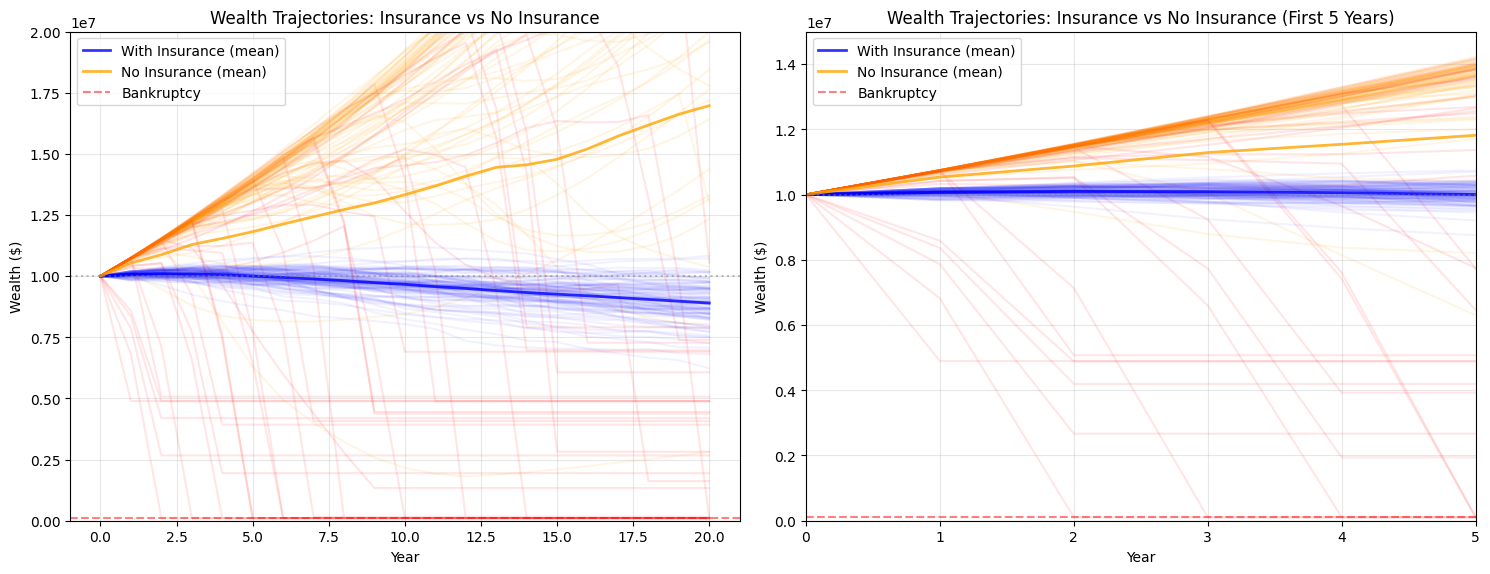

In [13]:
# Create comprehensive visualization
fig = plt.figure(figsize=(15, 6))

### Plot 1: Wealth trajectories comparison #######
ax1 = plt.subplot(1, 2, 1)

bankrupt_no_ins = []
bankrupt_with_ins = []

# Plot all scenarios
for idx, s in enumerate(scenarios_no_insurance):
    if idx in bankruptcy_no_ins_scenarios:
        ax1.plot(range(len(s)), s, color='red', alpha=0.1)
        bankrupt_no_ins.append(s)
    else:
        ax1.plot(range(len(s)), s, color='orange', alpha=0.1)
for idx, s in enumerate(scenarios_with_insurance):
    if idx in bankruptcy_with_ins_scenarios:
        bankrupt_with_ins.append(s)
    ax1.plot(range(len(s)), s, color='blue', alpha=0.05)

# Compute and overlay means
no_ins_mean = np.average(np.array(scenarios_no_insurance, dtype=float), axis=0)
with_ins_mean = np.average(np.array(scenarios_with_insurance, dtype=float), axis=0)

ax1.plot(range(len(with_ins_mean)), with_ins_mean, color='blue', linewidth=2, alpha=0.8, label='With Insurance (mean)')
ax1.plot(range(len(no_ins_mean)), no_ins_mean, color='orange', linewidth=2, alpha=0.8, label='No Insurance (mean)')
ax1.axhline(y=100_000, color='r', linestyle='--', alpha=0.5, label='Bankruptcy')
ax1.axhline(y=config.initial_assets, color='gray', linestyle=':', alpha=0.5)

ax1.set_xlabel('Year')
ax1.set_ylabel('Wealth ($)')
ax1.set_title('Wealth Trajectories: Insurance vs No Insurance')
ax1.set_ylim(0, 20_000_000)
ax1.legend()
ax1.grid(True, alpha=0.3)

### Plot 2: Wealth trajectories comparison #######
ax1 = plt.subplot(1, 2, 2)

# Plot all scenarios
for idx, s in enumerate(scenarios_no_insurance):
    if idx in bankruptcy_no_ins_scenarios:
        ax1.plot(range(len(s)), s, color='red', alpha=0.1)
        bankrupt_no_ins.append(s)
    else:
        ax1.plot(range(len(s)), s, color='orange', alpha=0.1)
for idx, s in enumerate(scenarios_with_insurance):
    if idx in bankruptcy_with_ins_scenarios:
        bankrupt_with_ins.append(s)
    ax1.plot(range(len(s)), s, color='blue', alpha=0.05)

# Compute and overlay means
no_ins_mean = np.average(np.array(scenarios_no_insurance, dtype=float), axis=0)

ax1.plot(range(len(with_ins_mean)), with_ins_mean, color='blue', linewidth=2, alpha=0.8, label='With Insurance (mean)')
ax1.plot(range(len(no_ins_mean)), no_ins_mean, color='orange', linewidth=2, alpha=0.8, label='No Insurance (mean)')
ax1.axhline(y=100_000, color='r', linestyle='--', alpha=0.5, label='Bankruptcy')
ax1.axhline(y=config.initial_assets, color='gray', linestyle=':', alpha=0.5)

ax1.set_xlabel('Year')
ax1.set_ylabel('Wealth ($)')
ax1.set_title('Wealth Trajectories: Insurance vs No Insurance (First 5 Years)')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 15_000_000)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Demonstrate the tax benefits of proper insurance cost treatment
print("=== Tax Treatment Demonstration ===")
print()

# Create test manufacturer
test_manufacturer = WidgetManufacturer(config)
print(f"Initial setup:")
print(f"  Assets: ${test_manufacturer.assets:,}")
print(f"  Tax rate: {test_manufacturer.tax_rate:.1%}")
print()

# Calculate baseline metrics before any insurance activity
revenue = test_manufacturer.calculate_revenue()
operating_income = test_manufacturer.calculate_operating_income(revenue)
print(f"Annual operations (before insurance):")
print(f"  Revenue: ${revenue:,.0f}")
print(f"  Operating Income: ${operating_income:,.0f}")
print()

# Scenario 1: No tax benefits (old method)
print("Scenario 1: Without proper tax treatment")
net_income_no_tax_benefit = test_manufacturer.calculate_net_income(
    operating_income, 0, 0, 0  # No insurance costs in tax calculation
)
premium_payment = 400_000  # $400K annual premium
loss_payment = 200_000     # $200K in deductibles/losses

# After-tax cost without deductibility
after_tax_premium_cost = premium_payment  # Full cost, no tax benefit
after_tax_loss_cost = loss_payment        # Full cost, no tax benefit

print(f"  Net income (no insurance): ${net_income_no_tax_benefit:,.0f}")
print(f"  Premium cost (no tax benefit): ${after_tax_premium_cost:,.0f}")
print(f"  Loss cost (no tax benefit): ${after_tax_loss_cost:,.0f}")
print(f"  Total after-tax cost: ${after_tax_premium_cost + after_tax_loss_cost:,.0f}")
print()

# Scenario 2: With proper tax benefits (new method)
print("Scenario 2: With proper tax treatment")
net_income_with_tax_benefit = test_manufacturer.calculate_net_income(
    operating_income, 0, premium_payment, loss_payment
)

# Tax benefit from deductible expenses
tax_savings = (premium_payment + loss_payment) * test_manufacturer.tax_rate
after_tax_cost_with_benefit = (premium_payment + loss_payment) - tax_savings

print(f"  Net income (with insurance costs): ${net_income_with_tax_benefit:,.0f}")
print(f"  Insurance costs (pre-tax): ${premium_payment + loss_payment:,.0f}")
print(f"  Tax savings (@{test_manufacturer.tax_rate:.1%}): ${tax_savings:,.0f}")
print(f"  After-tax cost: ${after_tax_cost_with_benefit:,.0f}")
print()

# Show the difference
savings = (after_tax_premium_cost + after_tax_loss_cost) - after_tax_cost_with_benefit
print(f"Tax benefit from proper treatment: ${savings:,.0f}")
print(f"Effective cost reduction: {savings / (premium_payment + loss_payment):.1%}")
print()
print("✅ Insurance premiums and losses are now properly tax-deductible!")

=== Tax Treatment Demonstration ===

Initial setup:
  Assets: $10,000,000.0
  Tax rate: 25.0%

Annual operations (before insurance):
  Revenue: $10,000,000
  Operating Income: $1,200,000

Scenario 1: Without proper tax treatment
  Net income (no insurance): $900,000
  Premium cost (no tax benefit): $400,000
  Loss cost (no tax benefit): $200,000
  Total after-tax cost: $600,000

Scenario 2: With proper tax treatment
  Net income (with insurance costs): $450,000
  Insurance costs (pre-tax): $600,000
  Tax savings (@25.0%): $150,000
  After-tax cost: $450,000

Tax benefit from proper treatment: $150,000
Effective cost reduction: 25.0%

✅ Insurance premiums and losses are now properly tax-deductible!


In [7]:
# Add diagnostic cell to analyze the results
print("=== Simulation Analysis ===")
print()

# Calculate some basic statistics
no_ins_final = [scenario[-1] for scenario in scenarios_no_insurance]
with_ins_final = [scenario[-1] for scenario in scenarios_with_insurance]

print(f"No Insurance Results:")
print(f"  Mean final wealth: ${np.mean(no_ins_final):,.0f}")
print(f"  Median final wealth: ${np.median(no_ins_final):,.0f}")
print(f"  Bankruptcy rate: {np.mean([w <= 100_000 for w in no_ins_final]):.1%}")
print(f"  Survivor count: {len([w for w in no_ins_final if w > 100_000])}/{len(no_ins_final)}")
print()

print(f"With Insurance Results:")
print(f"  Mean final wealth: ${np.mean(with_ins_final):,.0f}")
print(f"  Median final wealth: ${np.median(with_ins_final):,.0f}")
print(f"  Bankruptcy rate: {np.mean([w <= 100_000 for w in with_ins_final]):.1%}")
print(f"  Survivor count: {len([w for w in with_ins_final if w > 100_000])}/{len(with_ins_final)}")
print()

# Print premium information
print(f"Premium Analysis:")
print(f"  Annual premium baseline: ${annual_premium_baseline:,.0f}")
print(f"  As % of initial operating income: {annual_premium_baseline / 1_200_000:.1%}")
print(f"  Regular excess premium: ${regular_excess_pure_premium:,.0f}")
print(f"  Catastrophic excess premium: ${catastrophic_excess_pure_premium:,.0f}")
print()

# Check bankruptcy timing
no_ins_bankruptcies = []
with_ins_bankruptcies = []

for i, scenario in enumerate(scenarios_no_insurance):
    for year, wealth in enumerate(scenario):
        if wealth <= 100_000 and (year == 0 or scenario[year-1] > 100_000):
            no_ins_bankruptcies.append(year)
            break

for i, scenario in enumerate(scenarios_with_insurance):
    for year, wealth in enumerate(scenario):
        if wealth <= 100_000 and (year == 0 or scenario[year-1] > 100_000):
            with_ins_bankruptcies.append(year)
            break

if no_ins_bankruptcies:
    print(f"No Insurance - Average bankruptcy year: {np.mean(no_ins_bankruptcies):.1f}")
if with_ins_bankruptcies:
    print(f"With Insurance - Average bankruptcy year: {np.mean(with_ins_bankruptcies):.1f}")

=== Simulation Analysis ===

No Insurance Results:
  Mean final wealth: $19,488,000
  Median final wealth: $22,474,911
  Bankruptcy rate: 0.0%
  Survivor count: 100/100

With Insurance Results:
  Mean final wealth: $8,818,686
  Median final wealth: $8,873,081
  Bankruptcy rate: 0.0%
  Survivor count: 100/100

Premium Analysis:
  Annual premium baseline: $305,311
  As % of initial operating income: 25.4%
  Regular excess premium: $23,718
  Catastrophic excess premium: $190,000

